[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/ersip-sprint/blob/master/sprints/1/4%20-%20Attribute%20profiles.ipynb)

In [ ]:
# ! pip install sap
# ! wget https://github.com/kshitijrajsharma/ersip-sprint/raw/master/static/data.zip
# ! unzip data.zip
# ! rm data.zip

In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

/home/krschap/academia/ersip-sprint/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Attribute profiles (APs)

![](img/aps.png)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [3]:
tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
dsm = rio.open(tile_path).read(1)
max_tree = sap.MaxTree(dsm)
print(f"DSM shape: {dsm.shape}")
print(f"Max-tree nodes: {max_tree.num_nodes()}")

DSM shape: (2001, 2001)
Max-tree nodes: 6119633


## 1. Create the (max) attribute profiles of the DSM 

Compute the attribute profiles of the DSM with the max-tree *only* (normally it's min and max tree).

- Choose an attribute (e.g. `area`)
- Set several thresholds (e.g. `[1000, 10000, 100000]`)
- Filter the tree according to these thresholds, stack the filtered images!
- Display the profiles (as in the intro image)

Profiles stack shape: (4, 2001, 2001)


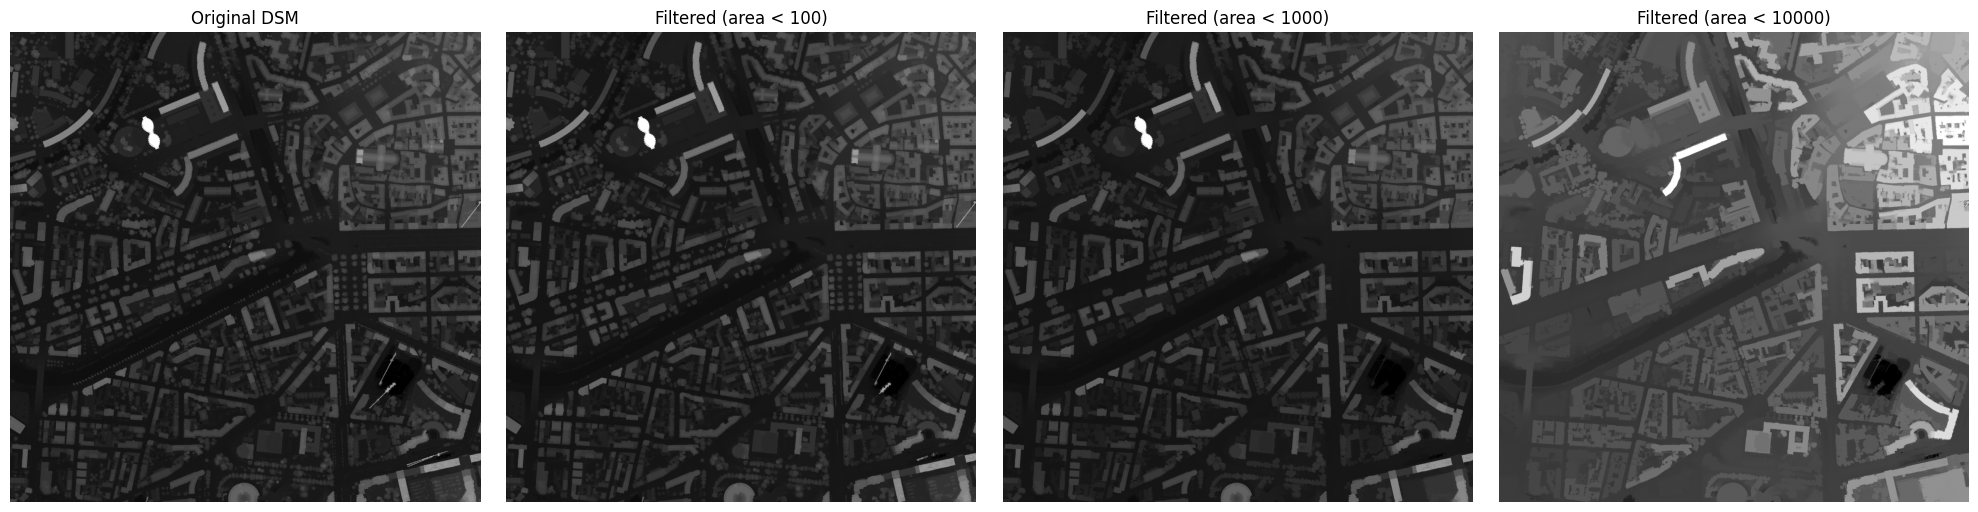

In [4]:
attribute_name = 'area'
thresholds = [100, 1000, 10000]
area = max_tree.get_attribute(attribute_name)

profiles_stack = []
profiles_stack.append(dsm)

for threshold in thresholds:
    deleted_nodes = area < threshold
    filtered = max_tree.reconstruct(deleted_nodes)
    profiles_stack.append(filtered)

profiles_stack = np.array(profiles_stack)
print(f"Profiles stack shape: {profiles_stack.shape}")

num_profiles = len(profiles_stack)
fig, axes = plt.subplots(1, num_profiles, figsize=(5 * num_profiles, 5))

axes[0].imshow(profiles_stack[0], cmap='gray')
axes[0].set_title('Original DSM')
axes[0].axis('off')

for i, threshold in enumerate(thresholds, start=1):
    axes[i].imshow(profiles_stack[i], cmap='gray')
    axes[i].set_title(f'Filtered (area < {threshold})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 2. Compute the Differential APs

The differential APs allows to see the structures removed at each thresholds.

- Compute the image differences from you attribute profiles stack
- Display!

Differential stack shape: (3, 2001, 2001)


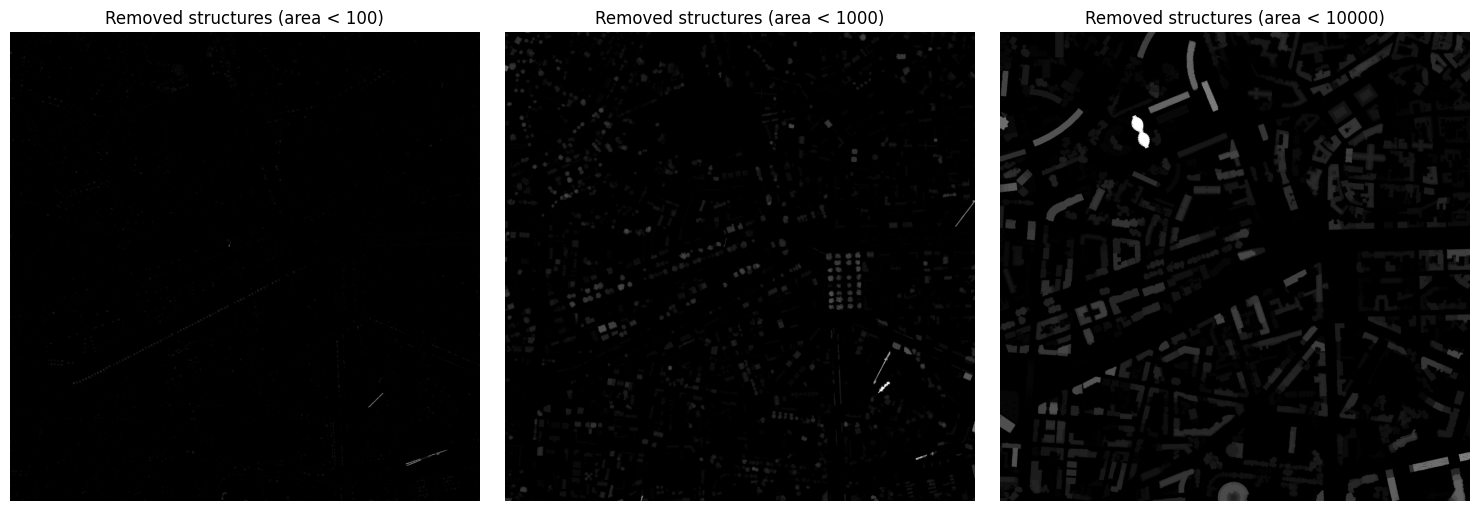

In [11]:
differential_stack = []
for i in range(len(profiles_stack) - 1):
    diff = profiles_stack[i] - profiles_stack[i + 1]
    differential_stack.append(diff)

differential_stack = np.array(differential_stack)
print(f"Differential stack shape: {differential_stack.shape}")

num_diff = len(differential_stack)
fig, axes = plt.subplots(1, num_diff, figsize=(5 * num_diff, 5))

if num_diff == 1:
    axes = [axes]

for i, threshold in enumerate(thresholds):
    axes[i].imshow(differential_stack[i], cmap='gray')
    axes[i].set_title(f'Removed structures (area < {threshold})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 3. Compute and display complete APs (min and max), Differential APs and Self-dual Attribute Profiles

In [7]:
# Don't panic, we'll use SAP!

aps = sap.attribute_profiles(dsm, {'area': thresholds})
daps = aps.diff()
sdaps = sap.self_dual_attribute_profiles(dsm, {'area': thresholds})


Total: 100%|██████████| 4/4 [00:00<00:00, 23.75it/s]


In [9]:
aps.data.shape, daps.data.shape, sdaps.data.shape

((7, 2001, 2001), (6, 2001, 2001), (4, 2001, 2001))

In [14]:
aps.len

1

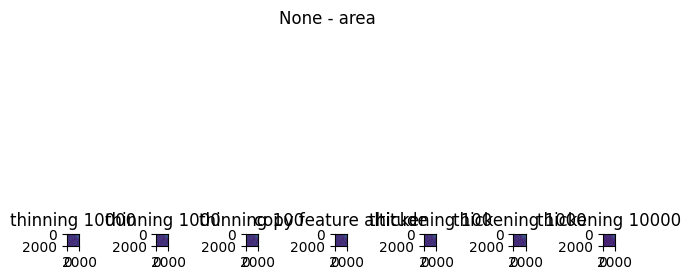

In [ ]:
sap.show_profiles(aps) # todo : fix this 